In [46]:
import os
import numpy as np
import pandas as pd
import librosa, librosa.display
import sklearn
import random as rn
import torch
import torch.nn as nn

In [47]:
pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i-a.shape[0])))
pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))

<h2>Wav 파일 MFCC 형태로 전처리</h2>

In [48]:
train_dataset = []
test_dataset = []
train_transcript = []
test_transcript = []

train_path = './data/3'
test_path = './data/2'

transcript = pd.read_table('./data/transcripts.txt',sep='|')
transcript_list = transcript['문장'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
transcript.drop(['문장2', '문장3','?','영문'], axis=1)
path_list = pd.DataFrame(transcript.파일명.str.split('/',3).tolist(),
                          columns= ['폴더','파일명'])
path_list = path_list['파일명']
transcript = pd.DataFrame({
    'filename':path_list,
    'script':transcript_list
})

transcript

,filename,script
0,1_0000.wav,그는 괜찮은 척하려고 애쓰는 것 같았다
1,1_0001.wav,그녀의 사랑을 얻기 위해 애썼지만 헛수고였다
2,1_0002.wav,용돈을 아껴 써라
3,1_0003.wav,그는 아내를 많이 아낀다
4,1_0004.wav,그 애 전화번호 알아
...,...,...
12849,4_5627.wav,깨진 유리 조각에 손가락을 벴어요
12850,4_5628.wav,아드님이 친구들과 야구를 하다 유리창을 깼어요
12851,4_5629.wav,일찍 신청하는 사람이 유리할 거야
12852,4_5630.wav,이 두 소설은 줄거리가 유사해요


In [49]:
train_X = []
train_y = []
test_X = []
test_y = []

In [50]:
import warnings

warnings.filterwarnings('ignore')

# train data
for filename in os.listdir(train_path):
    data = f'{train_path}/{filename}'
    wav, sr = librosa.load(data,sr=16000)
    mfcc = librosa.feature.mfcc(wav)
    padded_mfcc = pad2d(mfcc, 40)
    train_dataset.append(padded_mfcc)
    
    tuple = transcript[transcript['filename'].str.contains(filename)]
    script = tuple['script'].values[0]
    train_transcript.append(script)    

# test data
for filename in os.listdir(test_path):
    data = f'{test_path}/{filename}'
    wav, sr = librosa.load(data,sr=16000)
    mfcc = librosa.feature.mfcc(wav)
    padded_mfcc = pad2d(mfcc, 40)
    test_dataset.append(padded_mfcc)
    
    tuple = transcript[transcript['filename'].str.contains(filename)]
    script = tuple['script'].values[0]
    test_transcript.append(script)

In [51]:
train_X = train_dataset
test_X = test_dataset

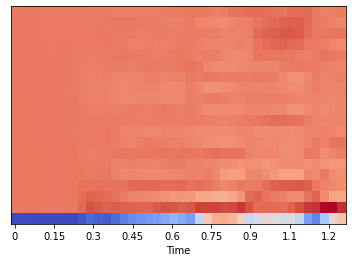

In [52]:
librosa.display.specshow(train_dataset[0], sr=16000, x_axis='time')

<h2>transcript 전처리</h2>

In [53]:
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [54]:
def preprocessing_okt(subject, okt, remove_stopwords = False, stop_words =[]):
  # 형태소 분석
  # okt는 별도로 스테머를 활용 가능
  subject_word = okt.morphs(subject,stem=True)
  if remove_stopwords:
    # 불용어 제거
    subject_word = [token for token in subject_word if not token in stop_words]
  return subject_word

In [55]:
# 불용어 리스트
clean_train_subject = []
train_ex = []
test_ex = []
stop_words = '다 은 는 이 가 하 아 것 들 의 있 자 되 수 보 주 등 고 한'.split()
okt = Okt()
for subject in transcript['script']:
    clean_train_subject.append(preprocessing_okt(subject,okt,remove_stopwords=True,stop_words= stop_words))
for subject in train_transcript:
    train_ex.append(preprocessing_okt(subject,okt,remove_stopwords=True,stop_words= stop_words))
for subject in test_transcript:
    test_ex.append(preprocessing_okt(subject,okt,remove_stopwords=True,stop_words= stop_words))
print(clean_train_subject[:10])

[['그', '괜찮다', '척', '하다', '애쓰다', '같다'], ['그녀', '사랑', '을', '얻다', '위해', '애쓰다', '헛', '수고', '이다'], ['용돈', '을', '아끼다', '써다'], ['그', '아내', '를', '많이', '아끼다'], ['그', '애', '전화번호', '알'], ['차', '에', '대해', '자다', '알다'], ['거기', '도착', '하다', '나', '한테', '알다', '주다'], ['그', '내', '시험', '에', '떨어지다', '알다', '오다'], ['나', '살아오다', '감기', '를', '앓다', '적', '하다', '번', '도', '없다'], ['사흘', '동안', '심하다', '몸살', '을', '앓다']]


In [56]:
# 단어 등장 빈도에 따른 정수값 부여
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_subject)

In [57]:
# 단어 사전
print(tokenizer.word_index)

{'하다': 1, '을': 2, '에': 3, '를': 4, '있다': 5, '그': 6, '저': 7, '사람': 8, '에서': 9, '보다': 10, '으로': 11, '없다': 12, '이다': 13, '로': 14, '되다': 15, '않다': 16, '우리': 17, '좀': 18, '제': 19, '요': 20, '나': 21, '안': 22, '에는': 23, '적': 24, '내': 25, '때': 26, '도': 27, '말': 28, '일': 29, '너무': 30, '좋다': 31, '오다': 32, '많다': 33, '그녀': 34, '하고': 35, '가다': 36, '예요': 37, '같다': 38, '오늘': 39, '자다': 40, '해': 41, '먹다': 42, '거': 43, '들다': 44, '게': 45, '어떻다': 46, '못': 47, '생각': 48, '싶다': 49, '줄다': 50, '더': 51, '이에요': 52, '시간': 53, '주다': 54, '에게': 55, '네': 56, '집': 57, '거야': 58, '한국': 59, '받다': 60, '돼다': 61, '되어다': 62, '아이': 63, '과': 64, '만': 65, '많이': 66, '말다': 67, '아니다': 68, '너': 69, '이번': 70, '지금': 71, '한테': 72, '중': 73, '왜': 74, '이야': 75, '와': 76, '정말': 77, '문제': 78, '책': 79, '차다': 80, '전': 81, '여자': 82, '몇': 83, '여기': 84, '줄': 85, '저희': 86, '까지': 87, '좋아하다': 88, '요즘': 89, '어제': 90, '회사': 91, '아직': 92, '알다': 93, '두': 94, '인': 95, '년': 96, '엄마': 97, '야': 98, '모두': 99, '친구': 100, '아내': 101, '마': 102, '아주': 103, '뭐': 10

In [58]:
# 단어 사전 분석
threshold = 3
word_vocab = tokenizer.word_index # 단어 사전 
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 7400
등장 빈도가 2번 이하인 희귀 단어의 수: 3650
단어 집합에서 희귀 단어의 비율: 49.32432432432432
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.19359717670784


In [59]:
vocab_size = total_cnt
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 7400


In [60]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(clean_train_subject) # 앞에서 토큰화가 완료된 단어집
train_y = tokenizer.texts_to_sequences(train_ex)
test_y = tokenizer.texts_to_sequences(test_ex)

In [61]:
print(train_y[:5])

[[92, 1466, 8, 1, 259, 51, 5], [5298, 9, 241, 557, 2, 460], [487, 259], [134, 130], [585, 59, 9, 176, 1151, 2321, 13]]


In [62]:
max_len = 10
train_y = pad_sequences(train_y, maxlen=max_len)
test_y = pad_sequences(test_y, maxlen=max_len)

In [63]:
train_X = np.array(train_X)
train_y = np.array(train_y)
test_X = np.array(test_X)
test_y = np.array(test_y)

In [64]:
print('train_X',train_X.shape)
print('train_y',train_y.shape)
print('test_X',test_X.shape)
print('test_y',test_y.shape)

train_X (5025, 20, 40)
train_y (5025, 10)
test_X (1157, 20, 40)
test_y (1157, 10)


In [65]:
train_X_ex = np.expand_dims(train_X, -1)
test_X_ex = np.expand_dims(test_X, -1)
print('train_X:', train_X_ex.shape)
print('test_X:', test_X_ex.shape)

train_X: (5025, 20, 40, 1)
test_X: (1157, 20, 40, 1)


<h2>CNN 모델 학습</h2>

In [66]:
import tensorflow as tf
from keras import Input
from keras.utils import to_categorical
from keras import Model
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, LSTM, Flatten, RepeatVector, Permute, Conv2D, MaxPooling2D 

In [67]:
ip = Input(shape=train_X_ex[0].shape)

m = Conv2D(32, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Conv2D(32*2, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Conv2D(32*3, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)

m = Flatten()(m)

m = Dense(64, activation='relu')(m)

m = Dense(32, activation='relu')(m)

op = Dense(10, activation='softmax')(m)

model = Model(ip, op)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20, 40, 1)]       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 17, 37, 96)        1632      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 4, 9, 96)         0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 3456)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                221248    
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                           

In [69]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X_ex,
                    train_y,
                    epochs=100,
                    batch_size=128,
                    verbose=1,
                    validation_data=(test_X_ex, test_y))

Epoch 1/100
40/40 [==============================] - 3s 63ms/step - loss: 339972800380928.0000 - accuracy: 0.1707 - val_loss: 234042347749376.0000 - val_accuracy: 0.1634
Epoch 2/100
40/40 [==============================] - 2s 51ms/step - loss: 345947972304896.0000 - accuracy: 0.1707 - val_loss: 237975732486144.0000 - val_accuracy: 0.1634
Epoch 3/100
40/40 [==============================] - 2s 52ms/step - loss: 351624207794176.0000 - accuracy: 0.1707 - val_loss: 241918697013248.0000 - val_accuracy: 0.1634
Epoch 4/100
40/40 [==============================] - 2s 51ms/step - loss: 358177992343552.0000 - accuracy: 0.1707 - val_loss: 246516946042880.0000 - val_accuracy: 0.1634
Epoch 5/100
40/40 [==============================] - 2s 54ms/step - loss: 364450154545152.0000 - accuracy: 0.1707 - val_loss: 250902912958464.0000 - val_accuracy: 0.1634
Epoch 6/100
40/40 [==============================] - 2s 52ms/step - loss: 371013971869696.0000 - accuracy: 0.1707 - val_loss: 255275575541760.0000 - v